In [1]:
import pandas as pd
import json
from PIL import Image, ImageDraw, ImageFont
import os
import random
import configparser



In [2]:
import configparser

config = configparser.ConfigParser()
config.read('config.ini', encoding='utf-8') 

JSONPATH = config['path']['train_json']
IMAGEPATH = config['path']['train_image']

In [3]:
def getDataFromJson(filePath):
	with open(filePath,"r") as f:
		return json.load(f)

In [4]:
rowData = getDataFromJson(JSONPATH)

In [5]:
pd.DataFrame(rowData['annotations'])

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4
...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142


In [6]:
def refineData(data):
	dataList = []
	for row in data['annotations']:
		imgId = row['image_id']
		imgRow = data['images'][imgId]
		categoryId = row["category_id"]
		categoryRow = data["categories"][categoryId]
		dataList.append({
			"image_id": imgId,
			"width": imgRow["width"],
			"height" : imgRow["height"],
			"file_name" : imgRow["file_name"],
			"category_id" : categoryId,
			"category_name" : categoryRow["name"],
			# "category_supercategory" : categoryRow["supercategory"], #똑같네...
			"area" : row["area"],
			"bbox" : row["bbox"],
			"iscrowd" : row["iscrowd"]
		})
	return dataList


In [7]:
refinedData = refineData(rowData)

In [8]:
df = pd.DataFrame(refinedData)
imageNumList = df["image_id"].unique()
df

,image_id,width,height,file_name,category_id,category_name,area,bbox,iscrowd
0,0,1024,1024,train/0000.jpg,0,General trash,257301.66,"[197.6, 193.7, 547.8, 469.7]",0
1,1,1024,1024,train/0001.jpg,3,Metal,10402.56,"[0.0, 407.4, 57.6, 180.6]",0
2,1,1024,1024,train/0001.jpg,7,Plastic bag,26259.36,"[0.0, 455.6, 144.6, 181.6]",0
3,1,1024,1024,train/0001.jpg,4,Glass,69096.17,"[722.3, 313.4, 274.3, 251.9]",0
4,1,1024,1024,train/0001.jpg,5,Plastic,24164.58,"[353.2, 671.0, 233.7, 103.4]",0
...,...,...,...,...,...,...,...,...,...
23139,4882,1024,1024,train/4882.jpg,5,Plastic,768591.81,"[0.0, 116.2, 944.1, 814.1]",0
23140,4882,1024,1024,train/4882.jpg,7,Plastic bag,57309.72,"[302.1, 439.3, 265.2, 216.1]",0
23141,4882,1024,1024,train/4882.jpg,0,General trash,1772.74,"[511.3, 451.1, 58.7, 30.2]",0
23142,4882,1024,1024,train/4882.jpg,1,Paper,53008.67,"[255.0, 421.4, 271.7, 195.1]",0


In [9]:
def getMatchedDataFrame(df,imageId):
	return df[df["image_id"]==imageId]

In [10]:
def getCategoryAndBboxByImageId(df,imageId):
	bboxList = []
	for _, row in getMatchedDataFrame(df,imageId).iterrows():
		bboxList.append((row["category_name"],row["bbox"]))
	return bboxList

In [11]:
def getPILImage(imageId, isTest=False):

	fileName = f"{imageId:04}.jpg"

	imagePath = os.path.join(IMAGEPATH,fileName)
	return Image.open(imagePath)


In [12]:
def drawBboxInImage(img, bboxList):
	draw = ImageDraw.Draw(img)
	for categoryName, bbox in bboxList:

		x1, y1, width, length = bbox
		draw.rectangle(((x1,y1),(x1+width,y1+length)),width=3 ,outline=(random.randint(0,255),random.randint(0,255),random.randint(0,255)))

		imageFont = ImageFont.load_default()
		text = categoryName
		text_width, text_height = imageFont.getsize(text)
		draw.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill=(0, 0, 0))
		draw.text((x1, y1 - text_height), text, font=imageFont, fill=(255, 255, 255))

	return img

In [13]:
def showImage(imageId, df=df):

	# imageId = 1 # 여기 바꿔서 확인해보기!

	bboxList = getCategoryAndBboxByImageId(df,imageId)
	img = getPILImage(imageId)
	imgs = drawBboxInImage(img,bboxList)

	return imgs

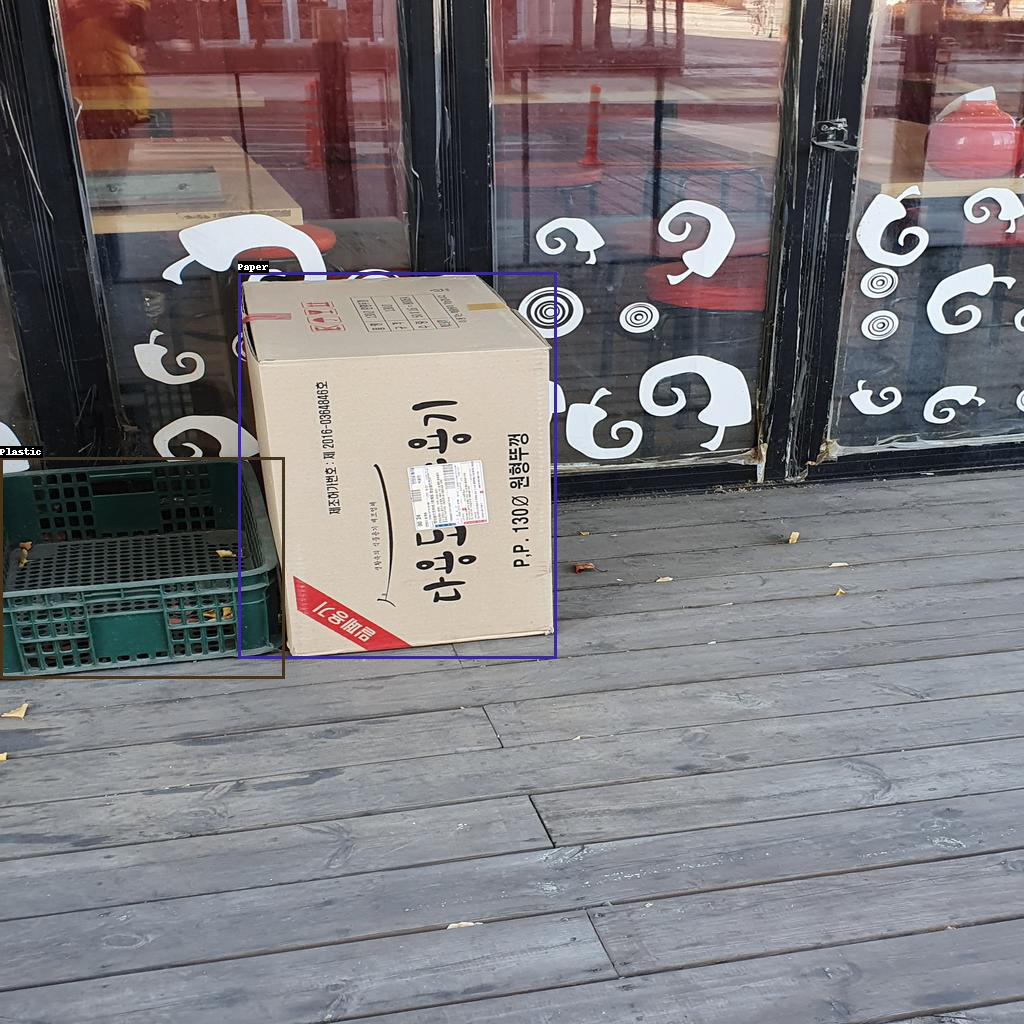

In [16]:
showImage(4272)